In [1061]:
import pandas as pd
import numpy as np
import datetime
import re
import json
import csv
from io import StringIO
import csvfile as csvfile
from bs4 import BeautifulSoup
import requests
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA

plt.style.use('fivethirtyeight')

#ignore harmless warnings
import warnings

warnings.filterwarnings("ignore")

url_stats = 'https://uk.finance.yahoo.com/quote/{}/key-statistics?p={}'
companies = ['TSLA', 'MSFT', 'AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX', 'SPOT', 'ZM', 'DBX', 'KO', 'DIS', 'PEP', 'ADBE', 'SONO', 'AMD', 'NVDA', 'INTC', 'NKE', 'NOK']
stock = 'TSLA'

def datetime_to_float(d):
    return d.timestamp()

In [1062]:
def getCSVS():
    #Statistics
    response = requests.get(url_stats.format(stock, stock))
    soup = BeautifulSoup(response.text, 'html.parser')
    pattern = re.compile(r'\s--\sData\s--\s')
    script_data = soup.find('script', text=pattern).contents[0]
    start = script_data.find("context")-2
    json_data = json.loads(script_data[start:-12])

    now = datetime.datetime.today().strftime('%Y-%m-%d')
    # print(now)

    #Historical Stock Data
    stock_url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?'

    params = {
        'start' : now,
        'interval' : '1d',
        'range' : '5y',
        'events' : 'history'
    }

    # response = requests.get(stock_url.format(stock), params=params)
    # response.text

    for s in companies:
        response = requests.get(stock_url.format(s), params=params)
        response.text

        file = StringIO(response.text)
        reader = csv.DictReader(file)
        with open('./csvs/'+s+'.csv', 'w', newline='') as f:
            fieldnames = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
            writer = csv.DictWriter(f, fieldnames=fieldnames)

            writer.writeheader()
            for row in reader:
                # writer.writerow({'Date': datetime_to_float(datetime.strptime(row['Date'], "%Y-%m-%d")), 'Open': row['Open'], 'High': row['High'], 'Low': row['Low'], 'Close': row['Close'], 'Adj Close': row['Adj Close'], 'Volume': row['Volume']})
                writer.writerow({'Date': row['Date'], 'Open': row['Open'], 'High': row['High'], 'Low': row['Low'], 'Close': row['Close'], 'Adj Close': row['Adj Close'], 'Volume': row['Volume']})

getCSVS()

In [1063]:
#Read data

stock_df=pd.read_csv('csvs/'+stock+".csv", index_col='Date', parse_dates=True)
print(stock_df.shape)
print(stock_df.head())

(1259, 6)
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2016-01-08  43.571999  44.088001  42.153999  42.200001  42.200001  18140500
2016-01-11  42.801998  42.889999  40.599998  41.570000  41.570000  20457000
2016-01-12  42.320000  42.748001  41.062000  41.993999  41.993999  15459500
2016-01-13  42.402000  42.529999  40.000000  40.062000  40.062000  20632000
2016-01-14  40.442001  42.000000  38.675999  41.236000  41.236000  32453500


In [1064]:
missing_data = stock_df[stock_df.isna().any(axis=1)]
print(missing_data)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


In [1065]:
print(stock_df)
stock_df = stock_df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
print(stock_df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-08   43.571999   44.088001   42.153999   42.200001   42.200001   
2016-01-11   42.801998   42.889999   40.599998   41.570000   41.570000   
2016-01-12   42.320000   42.748001   41.062000   41.993999   41.993999   
2016-01-13   42.402000   42.529999   40.000000   40.062000   40.062000   
2016-01-14   40.442001   42.000000   38.675999   41.236000   41.236000   
...                ...         ...         ...         ...         ...   
2020-12-31  699.989990  718.719971  691.119995  705.669983  705.669983   
2021-01-04  719.460022  744.489990  717.190002  729.770020  729.770020   
2021-01-05  723.659973  740.840027  719.200012  735.109985  735.109985   
2021-01-06  758.489990  774.000000  749.099976  755.979980  755.979980   
2021-01-07  777.630005  816.989990  775.200012  816.039978  816.039978   

              Volume  
Date          

In [1066]:
stock_df = stock_df.applymap(np.float)
print(stock_df)

                 Close
Date                  
2016-01-08   42.200001
2016-01-11   41.570000
2016-01-12   41.993999
2016-01-13   40.062000
2016-01-14   41.236000
...                ...
2020-12-31  705.669983
2021-01-04  729.770020
2021-01-05  735.109985
2021-01-06  755.979980
2021-01-07  816.039978

[1259 rows x 1 columns]


<AxesSubplot:xlabel='Date'>

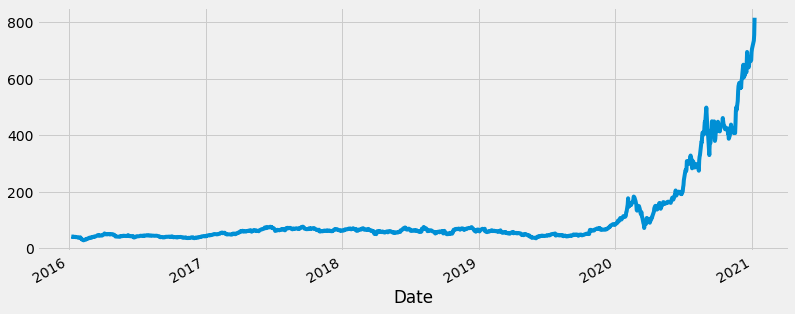

In [1067]:
stock_df['Close'].plot(figsize=(12,5))

In [1068]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag= 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num of observations used for adf regression and critical values calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

In [1069]:
ad_test(stock_df['Close'])

1. ADF :  6.638991830748495
2. P-Value :  1.0
3. Num Of Lags :  23
4. Num of observations used for adf regression and critical values calculation :  1235
5. Critical Values : 
	 1% :  -3.4356560275160835
	 5% :  -2.8638831211270817
	 10% :  -2.568017509711682


In [1070]:
#Stepwise to minimse aic value
stepwise_fit = auto_arima(stock_df, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=8651.064, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9511.129, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=9113.100, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=8648.827, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=8649.325, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=8649.373, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=8652.058, Time=0.29 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8648.719, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9513.103, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8649.236, Time=0.36 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=8649.284, Time=0.39 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9115.051, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=8651.948, Time=0.75 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 2.834 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -4321.360
Date:                Thu, 07 Jan 2021   AIC                           8648.719
Time:                        21:34:08   BIC                           8664.129
Sample:                             0   HQIC                          8654.510
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0046      0.004      1.156      0.248      -0.003       0.012
ma.L1         -0.9863      0.004   -251.247      0.000      -0.994      -0.979
sigma2        56.5387      0.561    100.817      0.000      55.440      57.638
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):             52736.18
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):             111.82   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1071]:
y_train, y_test = train_test_split(stock_df, test_size=0.1)
print(y_train.shape)
print(y_test.shape)

(881, 1)
(378, 1)


In [1072]:
model=ARIMA(y_train['Close'], order=(0,2,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                  879
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -5801.566
Method:                       css-mle   S.D. of innovations            177.220
Date:                Thu, 07 Jan 2021   AIC                          11609.133
Time:                        21:34:08   BIC                          11623.469
Sample:                             2   HQIC                         11614.616
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0007      0.024     -0.030      0.976      -0.047       0.045
ma.L1.D2.Close    -1.0000      0.003   -358.616      0.000      -1.005      -0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [1073]:
#Make predictions on Test Set
start=len(y_train)
end=len(y_train)+len(y_test)-1
pred=model.predict(start=start,end=end, typ='levels')
pred.index=stock_df.index[start:end+1]
print(pred)

Date
2019-07-11     46.483929
2019-07-12     46.197146
2019-07-15     45.909653
2019-07-16     45.621448
2019-07-17     45.332533
                 ...    
2020-12-31   -109.817620
2021-01-04   -110.369626
2021-01-05   -110.922344
2021-01-06   -111.475773
2021-01-07   -112.029913
Length: 378, dtype: float64


In [1074]:
#Dataset Mean
print(y_test['Close'].mean())
rmse = sqrt(mean_squared_error(pred, y_test['Close']))
print(rmse)

107.49995241269842
187.7177748391985


Date
2019-07-11     46.483929
2019-07-12     46.197146
2019-07-15     45.909653
2019-07-16     45.621448
2019-07-17     45.332533
                 ...    
2020-12-31   -109.817620
2021-01-04   -110.369626
2021-01-05   -110.922344
2021-01-06   -111.475773
2021-01-07   -112.029913
Length: 378, dtype: float64


<AxesSubplot:xlabel='Date'>

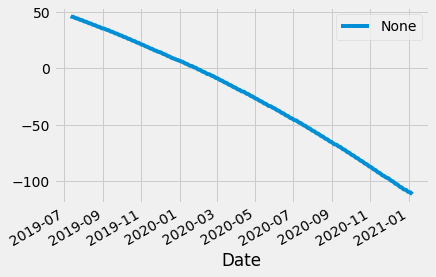

In [1075]:
print(pred)
pred.plot(legend=True)

In [1076]:
model2=ARIMA(stock_df['Close'], order=(3,1,3))
model2=model2.fit()
print(stock_df.tail())

                 Close
Date                  
2020-12-31  705.669983
2021-01-04  729.770020
2021-01-05  735.109985
2021-01-06  755.979980
2021-01-07  816.039978


In [1077]:
def getPred(numDays):
    currentDate = datetime.datetime.now()
    predDate = currentDate + datetime.timedelta(days=numDays)
    print(predDate.strftime('%Y-%m-%d'))

    index_future_dates=pd.date_range(start=currentDate,end=predDate)
    print(index_future_dates)

    pred=model2.predict(start=len(stock_df),end=len(stock_df)+numDays,typ='levels').rename('Prediction')
    pred.index=index_future_dates.strftime('%Y-%m-%d')
    print(pred)

    return pred

pred = getPred(30)

2021-02-06
DatetimeIndex(['2021-01-07 21:34:08.914254', '2021-01-08 21:34:08.914254',
               '2021-01-09 21:34:08.914254', '2021-01-10 21:34:08.914254',
               '2021-01-11 21:34:08.914254', '2021-01-12 21:34:08.914254',
               '2021-01-13 21:34:08.914254', '2021-01-14 21:34:08.914254',
               '2021-01-15 21:34:08.914254', '2021-01-16 21:34:08.914254',
               '2021-01-17 21:34:08.914254', '2021-01-18 21:34:08.914254',
               '2021-01-19 21:34:08.914254', '2021-01-20 21:34:08.914254',
               '2021-01-21 21:34:08.914254', '2021-01-22 21:34:08.914254',
               '2021-01-23 21:34:08.914254', '2021-01-24 21:34:08.914254',
               '2021-01-25 21:34:08.914254', '2021-01-26 21:34:08.914254',
               '2021-01-27 21:34:08.914254', '2021-01-28 21:34:08.914254',
               '2021-01-29 21:34:08.914254', '2021-01-30 21:34:08.914254',
               '2021-01-31 21:34:08.914254', '2021-02-01 21:34:08.914254',
              

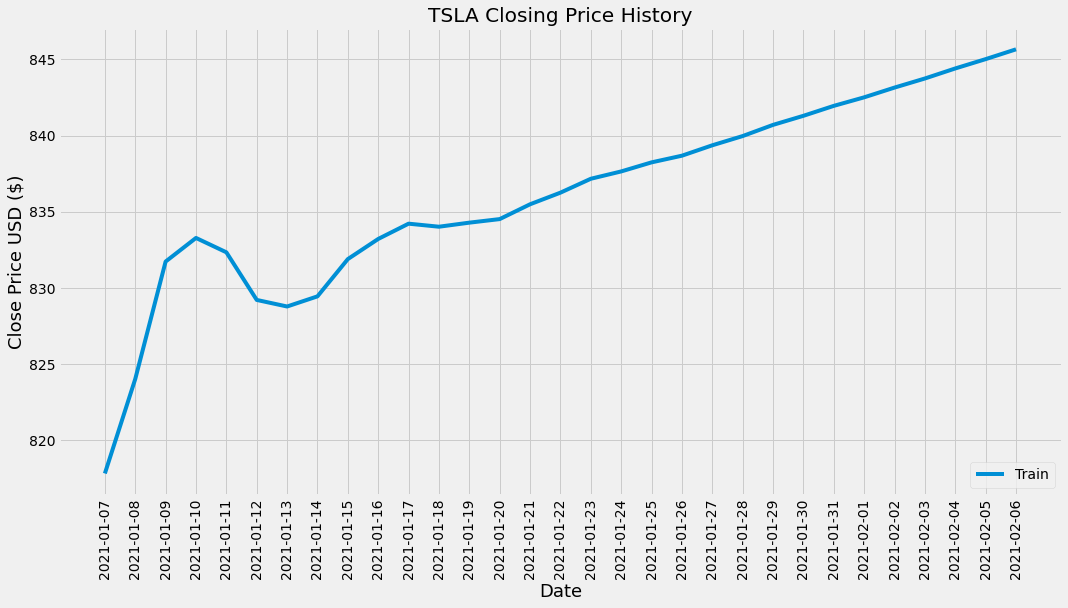

In [1078]:
# pred.plot(figsize=(12,5), legend=True)
plt.figure(figsize=(16,8))
plt.title(stock+' Closing Price History')
plt.plot(pred)
plt.xlabel('Date', fontsize=18)
plt.xticks(rotation=90)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train'], loc='lower right')
plt.show()
